In [506]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [507]:
# Реших да използвам пайплайн чейнинга, който показахте на една лекция като отправна точка
titanic = pd.read_csv('train.csv')

class StringImputer(TransformerMixin):
    def fit(self, X, *_):
        self.modes = X.mode().iloc[0]
        return self
        
    def transform(self, X, y=None):
        return X.fillna(self.modes)

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[[self.key]]

class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        super().fit(X)

    def transform(self, X, y=None):
        return super().transform(X)

    def fit_transform(self, X, y=None):
        return super().fit(X).transform(X)
    


In [508]:
# ето го и него
model = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('imputer', Imputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('sibsp', Pipeline([
            ('select', ItemSelector('SibSp')),
            ('scaler', StandardScaler()),
        ])),
        ('parch', Pipeline([
            ('select', ItemSelector('Parch')),
            ('scaler', StandardScaler()),
        ])),
    ])),
    ('svc', SVC())
])

scores = cross_val_score(model, titanic, titanic['Survived'])
print(scores)
print(scores.mean())

[ 0.81144781  0.83164983  0.82491582]
0.822671156004


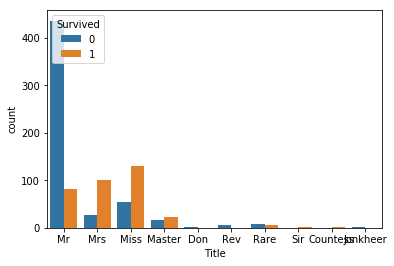

In [509]:
# след това добавих фийчърите, които разгледахме - титла (извлечена от името), но с тази разлика, че 
# не изключих всички рядко срещани титли като Rare, защото видях, че някои от тях са религиозни или много високи
# и реших, че могат да помогнат
titanic['Title'] = titanic.Name.str.extract('([A-Za-z]+)\.', expand=False)
titanic.loc[titanic.Title == 'Mlle', 'Title'] = 'Miss'
titanic.loc[titanic.Title == 'Mme', 'Title']  = 'Mrs'
titanic.loc[titanic.Title == 'Ms', 'Title']   = 'Miss'
titanic.loc[titanic.Title == 'Lady', 'Title']   = 'Miss'
rare_titles = ['Dr', 'Col', 'Major', 'Capt']
titanic.Title = titanic.Title.replace(rare_titles, 'Rare')
titanic.Title.value_counts()
sns.countplot('Title', hue='Survived', data=titanic);
data = titanic.copy()

In [510]:
# На графиката се вижда, че има титли с 100% оцелели/загинали, което сигурно е заради сета, но все пак ги оставих
# Тук запълвам липсващите години в зависимост от титлата и смятам големината на семейството, с което е пътувал човека
data = titanic.copy()
age_by_title = data.groupby('Title').Age.mean()

data.loc[data.Age.isnull() & (data.Title == 'Mr'), 'Age'] = age_by_title['Mr']
data.loc[data.Age.isnull() & (data.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
data.loc[data.Age.isnull() & (data.Title == 'Miss'), 'Age'] = age_by_title['Miss']
data.loc[data.Age.isnull() & (data.Title == 'Master'), 'Age'] = age_by_title['Master']
data.loc[data.Age.isnull() & (data.Title == 'Rare'), 'Age'] = age_by_title['Rare']

data['FamilySize'] = data.Parch + data.SibSp + 1

In [511]:
# нека да видим какво ще получи модела така
model = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('imputer', Imputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ])),
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('pclass', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('scaler', StandardScaler()),
        ])),
        ('fare', Pipeline([
            ('select', ItemSelector('Fare')),
            ('scaler', StandardScaler()),
        ])),
        ('sibsp', Pipeline([
            ('select', ItemSelector('SibSp')),
            ('scaler', StandardScaler()),
        ])),
        ('parch', Pipeline([
            ('select', ItemSelector('Parch')),
            ('scaler', StandardScaler()),
        ])),
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('imputer', Imputer(strategy='mean')),
        ])),
    ])),
    ('svc', SVC())
])

scores = cross_val_score(model, data, titanic['Survived'])
print(scores)
print(scores.mean())

[ 0.81481481  0.84175084  0.83838384]
0.83164983165


In [512]:
# Резултатът е по-добър, но не и Кегъл (не очаквах да е толкова лесно)
# Ще въпреки, че той ще корелира с някои от другите, ще добавя фийчър, който да казва дали един човек е майка на малко дете
extended = data.copy()
extended['IsMommy'] = False
extended.loc[(extended.Sex == 'female') & (extended.Parch > 0) & (extended.Age < 26) & (extended.Age > 19), 'IsMommy'] = True

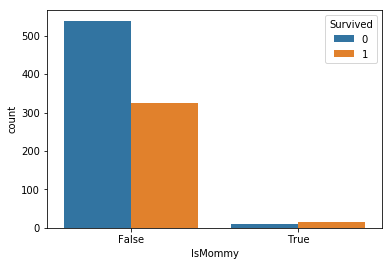

In [513]:
# Както очаквах, има доста добър шанс такава майка да оцелее
sns.countplot('IsMommy', hue='Survived', data=extended);

In [514]:
# Нека да го включим в модела и да видим какво ще стане
model = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('imputer', Imputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ])),
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('pclass', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('scaler', StandardScaler()),
        ])),
        ('fare', Pipeline([
            ('select', ItemSelector('Fare')),
            ('scaler', StandardScaler()),
        ])),
        ('sibsp', Pipeline([
            ('select', ItemSelector('SibSp')),
            ('scaler', StandardScaler()),
        ])),
        ('parch', Pipeline([
            ('select', ItemSelector('Parch')),
            ('scaler', StandardScaler()),
        ])),
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('imputer', Imputer(strategy='mean')),
        ])),
        ('is_mommy', Pipeline([
            ('select', ItemSelector('IsMommy')),
        ])),
    ])),
    ('svc', SVC())
])

scores = cross_val_score(model, extended, titanic['Survived'])
print(scores)
print(scores.mean())

[ 0.81481481  0.84175084  0.84175084]
0.832772166105


In [515]:
# До някъде очаквано, не даде подобрение. Нищо, ще го ползвам по-натам
# Ще обогатя още данните с два фийчъра, които ще имат за цел да ни казват положението на каютата на кораба
# Буквата в Cabin показва разположение на каютата, а числото е четно/нечетно в зависимост от това дали каютата
# e ляво или дясно на борд
extended['RightOnBoard'] = False
extended['LeftOnBoard'] = False
extended['CabNumber'] = extended.Cabin.str.extract('([0-9]+)', expand=False)
extended.loc[pd.to_numeric(extended.CabNumber) % 2 == 1, 'RightOnBoard'] = True
extended.loc[pd.to_numeric(extended.CabNumber) % 2 == 0, 'LeftOnBoard'] = True
extended['CabinLet'] = extended.Cabin.str.extract('([A-Z]+)', expand=False)
extended.loc[extended.CabinLet.isnull() , 'CabinLet'] = 'Z'

# Още един на пръв поглед ненужен фийчър - дали човека е малко дете, който ще наименовам IsLuckyAge - не е ли вярно?! 
extended['IsLuckyAge'] = False
extended.loc[(extended.Age >= 3) & (extended.Age <= 8), 'IsLuckyAge'] = True
extended.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsMommy,RightOnBoard,LeftOnBoard,CabNumber,CabinLet,IsLuckyAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,False,False,False,NaN,Z,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,False,True,False,85,C,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,False,False,False,NaN,Z,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,False,True,False,123,C,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,False,False,False,NaN,Z,False


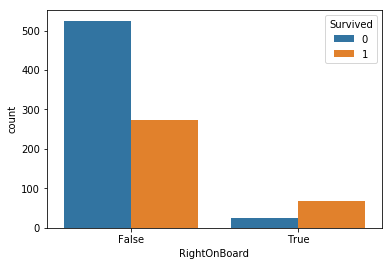

In [516]:
# Дясно на борд явно са били късметлии
sns.countplot('RightOnBoard', hue='Survived', data=extended)

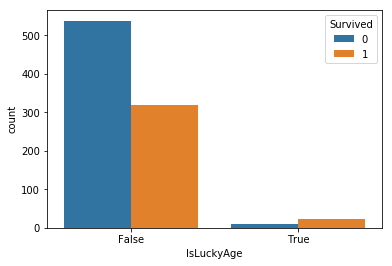

In [517]:
# Очаквано, "Първо жените и децата!"
sns.countplot('IsLuckyAge', hue='Survived', data=extended)

In [518]:
# Пробваме отново, RandomForest и  SVC
model_witch_cabin_data = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('imputer', Imputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ])),
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('pclass', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('scaler', StandardScaler()),
        ])),
        ('fare', Pipeline([
            ('select', ItemSelector('Fare')),
            ('scaler', StandardScaler()),
        ])),
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('imputer', Imputer(strategy='mean')),
        ])),
        ('is_mommy', Pipeline([
            ('select', ItemSelector('IsMommy')),
        ])),
        ('is_lucky', Pipeline([
            ('select', ItemSelector('IsLuckyAge')),
        ])),
        ('is_right', Pipeline([
            ('select', ItemSelector('RightOnBoard')),
        ]))
        
    ])),
    ('rand_forest', RandomForestClassifier(max_depth=4, n_estimators=7))

])

scores = cross_val_score(model_witch_cabin_data, extended, extended['Survived'])
print(scores)
print(scores.mean())

[ 0.79461279  0.83501684  0.81818182]
0.81593714927


In [519]:
model_witch_cabin_data = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('imputer', Imputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ])),
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('pclass', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('scaler', StandardScaler()),
        ])),
        ('fare', Pipeline([
            ('select', ItemSelector('Fare')),
            ('scaler', StandardScaler()),
        ])),
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('imputer', Imputer(strategy='mean')),
        ])),
        ('is_mommy', Pipeline([
            ('select', ItemSelector('IsMommy')),
        ])),
        ('is_lucky', Pipeline([
            ('select', ItemSelector('IsLuckyAge')),
        ])),
        ('is_right', Pipeline([
            ('select', ItemSelector('RightOnBoard')),
        ]))
        
    ])),
    ('svc', SVC(C=5))

])

scores = cross_val_score(model_witch_cabin_data, extended, extended['Survived'])
print(scores)
print(scores.mean())

[ 0.82154882  0.84511785  0.84175084]
0.836139169473


In [520]:
# SVC даде доста по-добър резултат, но резултатът в Кегъл не е подобрен, даже се смъкна. Предполагам заради голямата
# зависимост на фийчърите. Също така, оказва се че буквата на кабината не ни дава никакъв бонус, а обратното
# Тъй като вкарахдва фийчъра, които се препокриват с годините, а смятам че годините не са много важни в останалите случаи
# ще пробвам без тях
model_witch_cabin_data = Pipeline([
    ('union', FeatureUnion([
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('pclass', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('scaler', StandardScaler()),
        ])),
        ('fare', Pipeline([
            ('select', ItemSelector('Fare')),
            ('imputer', Imputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ])),
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('imputer', Imputer(strategy='mean')),
        ])),
        ('is_mommy', Pipeline([
            ('select', ItemSelector('IsMommy')),
        ])),
        ('is_lucky', Pipeline([
            ('select', ItemSelector('IsLuckyAge')),
        ])),
        ('is_right', Pipeline([
            ('select', ItemSelector('RightOnBoard')),
        ])),
    ])),
    ('svc', SVC(C=4))

])

scores = cross_val_score(model_witch_cabin_data, extended, extended['Survived'])
print(scores)
print(scores.mean())

[ 0.82828283  0.84511785  0.84511785]
0.83950617284


In [521]:
# подобрих значително крос валидацията, но при събнит получих малко по-нисък резултат от този на лекция
# пробвам и RandomForest
model_witch_cabin_data = Pipeline([
    ('union', FeatureUnion([
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('pclass', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('scaler', StandardScaler()),
        ])),
        ('fare', Pipeline([
            ('select', ItemSelector('Fare')),
            ('imputer', Imputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ])),
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('imputer', Imputer(strategy='mean')),
        ])),
        ('is_mommy', Pipeline([
            ('select', ItemSelector('IsMommy')),
        ])),
        ('is_lucky', Pipeline([
            ('select', ItemSelector('IsLuckyAge')),
        ])),
        ('is_right', Pipeline([
            ('select', ItemSelector('RightOnBoard')),
        ])),
    ])),
    ('rand_forest', RandomForestClassifier(max_depth=4, n_estimators=7))

])

scores = cross_val_score(model_witch_cabin_data, extended, extended['Survived'])
print(scores)
print(scores.mean())

[ 0.75420875  0.82828283  0.81144781]
0.79797979798


In [522]:
# Рандом фореста се справи малко по-зле, но все пак събмитнах и двете и там той беше по-добър.
# В крайна сметка подобрих резултата от модела на лекция с един процент с RandomForest
test_data = pd.read_csv('test.csv', index_col=['PassengerId'])

test_data['Title'] = test_data.Name.str.extract('([A-Za-z]+)\.', expand=False)
test_data.loc[test_data.Title == 'Mlle', 'Title'] = 'Miss'
test_data.loc[test_data.Title == 'Mme', 'Title']  = 'Mrs'
test_data.loc[test_data.Title == 'Ms', 'Title']   = 'Miss'
test_data.loc[test_data.Title == 'Lady', 'Title']   = 'Miss'
rare_titles = ['Dr', 'Col', 'Major', 'Capt']
test_data.Title = test_data.Title.replace(rare_titles, 'Rare')
test_data.Title.value_counts()

age_by_title = test_data.groupby('Title').Age.mean()

test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Mr'), 'Age'] = age_by_title['Mr']
test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Miss'), 'Age'] = age_by_title['Miss']
test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Master'), 'Age'] = age_by_title['Master']
test_data.loc[test_data.Age.isnull() & (test_data.Title == 'Rare'), 'Age'] = age_by_title['Rare']

test_data['FamilySize'] = test_data.Parch + test_data.SibSp + 1
test_data['IsMommy'] = False
test_data.loc[(test_data.Sex == 'female') & (test_data.Parch > 0) & (test_data.Age < 26) & (test_data.Age > 19), 'IsMommy'] = True
test_data['RightOnBoard'] = False
test_data['CabNumber'] = test_data.Cabin.str.extract('([0-9]+)', expand=False)
test_data.loc[pd.to_numeric(test_data.CabNumber) % 2 == 1, 'RightOnBoard'] = True
test_data['LeftOnBoard'] = False
test_data['CabinLet'] = test_data.Cabin.str.extract('([A-Z]+)', expand=False)
test_data.loc[test_data.CabinLet.isnull() , 'CabinLet'] = 'Z'
test_data.loc[pd.to_numeric(test_data.CabNumber) % 2 == 0, 'LeftOnBoard'] = True
test_data['IsLuckyAge'] = False
test_data.loc[(test_data.Age >= 3) & (test_data.Age <= 8), 'IsLuckyAge'] = True
test_data.isnull().sum().sort_values()

feature_union = FeatureUnion([
        ('title', Pipeline([
            ('select', ItemSelector('Title')),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('pclass', Pipeline([
            ('select', ItemSelector('Pclass')),
            ('scaler', StandardScaler()),
        ])),
        ('fare', Pipeline([
            ('select', ItemSelector('Fare')),
            ('imputer', Imputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ])),
        ('family_size', Pipeline([
            ('select', ItemSelector('FamilySize')),
            ('imputer', Imputer(strategy='mean')),
        ])),
        ('is_mommy', Pipeline([
            ('select', ItemSelector('IsMommy')),
        ])),
        ('is_lucky', Pipeline([
            ('select', ItemSelector('IsLuckyAge')),
        ])),
        ('is_right', Pipeline([
            ('select', ItemSelector('RightOnBoard')),
        ])),
        
    ])

transformed_train_data = feature_union.fit_transform(extended)
transformed_test_data = feature_union.transform(test_data)

# final_model = SVC(C=4).fit(transformed_train_data, test['Survived'])
from sklearn.ensemble import RandomForestClassifier
final_model = RandomForestClassifier(max_depth=4, n_estimators=7).fit(transformed_train_data, test['Survived'])

predictions = final_model.predict(transformed_test_data)
frame = pd.DataFrame({
    'PassengerId': pd.read_csv('test.csv').PassengerId,
    'Survived': predictions
})
frame = frame.set_index('PassengerId')
frame.to_csv('./predictions.csv')
frame.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
